## Homework Week4

In [0]:
%matplotlib inline
!pip install tensorboardcolab

import tensorboardcolab
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


### 1. 망델브롯 Fractal 구현하고 텐서 보드에 연결하기

Instructions for updating:
Colocations handled automatically by placer.
Wait for 8 seconds...
TensorBoard link:
https://b97ec4e4.ngrok.io


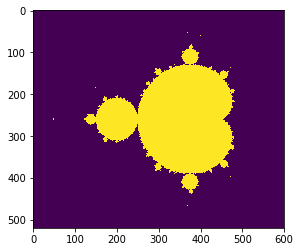

In [0]:
tf.reset_default_graph()

# add tensorboard
# input initial value
Y, X = np.mgrid[-1.3:1.3:0.005, -2:1:0.005]
init_value = X + 1j*Y

with tf.name_scope('cal'):
    xs = tf.constant(init_value, name='xs')
    zs = tf.Variable(xs, name='zs')
    zs_square = tf.multiply(zs, zs, name='zs_squre')
    zs_add = tf.add(xs, zs_square, name='zs_add')
    zs_abs = tf.abs(zs_add, name='zs_abs')
    zs_less = tf.math.less(zs_abs, 4)
    zs_cast = tf.cast(zs_less, tf.float32)
    
    zs_zeros = tf.zeros_like(xs, tf.float32)
    ns = tf.Variable(zs_zeros,name='ns')


step = tf.group(
  tf.assign(ns, zs_cast),
  tf.assign(zs, zs_add),
  name = 'step'
)    
    
# Step1 : add tensor to tensorboard
ns_image_tb = tf.summary.image(name='ns_image', tensor=tf.reshape(ns, shape=[1,520,600,1]))
ns_mean_tb = tf.summary.scalar(name='ns_mean', tensor=tf.reduce_mean(ns))
ns_hist_tb = tf.summary.histogram(name='ns_hist', values=ns)


sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Step2 : 기록
saver = tf.train.Saver()
tbs = tf.summary.merge_all()

tbc=tensorboardcolab.TensorBoardColab(graph_path='./mandelbrot')
writer = tf.summary.FileWriter(logdir = './mandelbrot')
writer.add_graph(tf.get_default_graph())


# Step3 :언제마다 기록하고 싶은가
for i in range(200):
    _, tbs_ = sess.run([step,tbs])   # sess.run에 merge한걸 넣어서 돌리면 된다.
    writer.add_summary(tbs_, global_step=i)
    
writer.flush()

saver.save(sess, save_path='./model/mandelbrot')
value = sess.run(ns)
plt.imshow(value)
plt.show()

# Step 4: 실행된 텐서보드를 보자.

### 2. Julia fractal 구현하기.

Wait for 8 seconds...
TensorBoard link:
https://b97ec4e4.ngrok.io


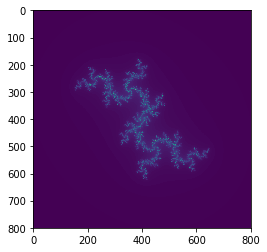

In [0]:
tf.reset_default_graph()

# add tensorboard
# input initial value
Y,X = np.mgrid[-2:2:0.005 , -2:2:0.005]
init_value = X + 1j*Y

with tf.name_scope('cal'):
    xs = tf.constant(init_value, name='xs')
    zs = tf.Variable(xs, name='zs')
    zs_square = tf.multiply(zs, zs, name='zs_squre')
    input_value = 0 + 0.75j
    zs_sub = tf.subtract(zs_square, input_value)
    zs_abs = tf.abs(zs_sub)
    zs_less = tf.math.less(zs_abs, 4)
    zs_cast = tf.cast(zs_less, tf.float32)  
    
    zs_zeros = tf.zeros_like(xs, tf.float32)
    ns = tf.Variable(zs_zeros,name='ns')


step = tf.group(
  tf.assign(zs, zs_sub),
  tf.assign_add(ns, zs_cast),
  name = 'step'
)    
    
# Step1 : add tensor to tensorboard
ns_image_tb = tf.summary.image(name='ns_image',
                               tensor=tf.reshape(ns,shape=[1,800,800,1]))
ns_mean_tb = tf.summary.scalar(name='ns_mean',
                               tensor=tf.reduce_mean(ns))
ns_hist_tb = tf.summary.histogram(name='ns_hist',
                                 values=ns)


sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Step2 : 기록
saver = tf.train.Saver()
tbs = tf.summary.merge_all()

tbc=tensorboardcolab.TensorBoardColab(graph_path='./mandelbrot')
writer = tf.summary.FileWriter(logdir = './mandelbrot')
writer.add_graph(tf.get_default_graph())

# Step3 :언제마다 기록하고 싶은가
for i in range(200):
    _, tbs_ = sess.run([step,tbs])   # sess.run에 merge한걸 넣어서 돌리면 된다.
    writer.add_summary(tbs_, global_step=i)
    
writer.flush()

saver.save(sess,
           save_path='./model/mandelbrot')
value = sess.run(ns)
plt.imshow(value)
plt.show()

# Step 4: 실행된 텐서보드를 보자.

### 3. rain Drop 을 구현해주세요

In [0]:
# 우선 아래 코드를 실행해 주세요 
# Laplace은 아래 코드를 사용하세요
def laplace(x):
    def make_kernel(a):
        """Transform a 2D array into a convolution kernel"""
        a = np.asarray(a)
        a = a.reshape(list(a.shape) + [1, 1])
        return tf.constant(a, dtype=1)

    def simple_conv(x, k):
        """A simplified 2D convolution operation"""
        x = tf.expand_dims(tf.expand_dims(x, 0), -1)
        y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
        return y[0, :, :, 0]
    """Compute the 2D laplacian of an array"""

    laplace_k = make_kernel([[0.5, 1.0, 0.5],
                             [1.0, -6., 1.0],
                             [0.5, 1.0, 0.5]])
    return simple_conv(x, laplace_k)


# 임의의 좌표에 임의의 값 40개를 생성 합니다. 
N = 500
u_init = np.zeros([500,500] , dtype=np.float32)
ut_init = np.zeros([500,500] , dtype=np.float32)

for n in range(40):
    a, b = np.random.randint(0, N, 2)
    u_init[a,b] = np.random.uniform()

In [0]:
graph = tf.Graph()
with graph.as_default():
    
    eps = tf.placeholder(tf.float32, shape=())
    damping = tf.placeholder(tf.float32, shape=())
    
    # Create variables for simulation state
    U = tf.Variable(u_init, name='U')
    Ut = tf.Variable(ut_init, name='Ut')
    
        
    ### U와 Ut의 값을 갱신하는 연산
    
    with tf.name_scope(name='update_op'):  ### 묶어준다.
        # U = U + Ut * eps
        # add1 = tf.add(U, eps)
        value1 = tf.multiply(eps, Ut)  
    
        # Ut = Ut + (Ut*damping - laplace(U)) * eps    
        mul1 = tf.multiply(Ut, damping)
        sub1 = tf.subtract(laplace(U), mul1)
        mul2 = tf.multiply(sub1, eps)
    
    step = tf.group(
        tf.assign_add(U, value1),  # ref가 variable, value가  tf.assign()
        tf.assign_add(Ut, mul2), #
        name = 'step'
    )
    
    update_op = step
    
    ### 평가 그래프
    with tf.name_scope(name='output'):  ### 묶어준다.
        const1 = tf.constant(0.1, tf.float32)
        test_add = tf.add(U, const1)
        
        const2 = tf.constant(0.2, tf.float32)
        test_div = tf.math.divide(test_add, const2)
        
        const3 = tf.constant(255, tf.float32)
        test_mul = tf.multiply(test_div, const3)
    
        clip_by_value = tf.clip_by_value(test_mul, 0, 255)
        clip_by_value = tf.cast(clip_by_value, tf.uint8)
        output = clip_by_value

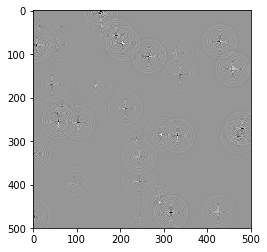

In [0]:
with graph.as_default():
    sess = tf.Session(graph=graph)
    sess.run(tf.global_variables_initializer())

    for i in range(1000):
        sess.run(update_op, {eps: 0.03, damping: 0.04})

    result = sess.run(output)    
    
plt.imshow(result, cmap='Greys')
plt.show()

### 4. Kmeans , KNN 을 Tensorflow 로 구현해 주세요.

### 1) KNN


#### 데이터 ) 각 영화 별 싸움 횟수와 키스 횟수

| 영화 제목 | the number of Kick | The number os Kiss | Type |
| ------  | ----| ----| --- |
| 냉정과열정사이 | 3 | 104 | Romance|
| 바람과함께사라지다 | 2 | 100 | Romance |
| 아름다운 여인 | 1 | 81 | Romance |
| 인정사정볼것없다 | 101 | 10 | Action |
| 놈놈놈 | 99 | 5 | Action |
| 화랑 | 98 | 2 | Action |
| 뜨거운 가슴으로 | 25 | 87 | ? |


#### 알고리즘 탐색하기
---
KNN의 알고리즘 순서

1. 우리가 분류항목을 알고자 하는 점(inX)와 알고 있는 점들(dataset)과의 모든 점 거리를 계산
2. 오름 차순으로 거리의 길이를 정렬
3. inX와의 거리가 가장 짧은 K개의 아이템 추출
4. K개의 아이템에서 가장 많은 분류 항목 찾기
5. 해당 항목 반환


아래 코드는 Numpy 로 KNN을 구현한 코드 입니다.

---

In [0]:
# 0번째 열 : 킥 횟수, 1번째 열 : 키스 횟수
dataset = np.array([
    [3, 104],
    [2, 100],
    [1, 81],
    [101, 10],
    [99, 5],
    [98, 2],
])

labels = np.array(['Romance','Romance','Romance',
          'Action','Action','Action'])

inX = np.array([25, 87])

In [0]:
def classify_knn(inX, dataset, labels, K):
    # (1) 우리가 분류항목을 알고자 하는 점 (inX)와 
    # 알고 있는 점들(dataset)과의 모든 점 거리를 계산
    dists = np.sqrt(np.sum((inX-dataset)**2, axis=1))
    
    
    # (2) 오름 차순으로 거리의 길이를 정렬
    sorted_index = dists.argsort()     # 순서대로 index를 반환해준다. # 작은게 0, 큰거는 마지막숫자임.
    
    
    # (3) inX와의 거리가 가장짧은 K개의 아이템 추출
    sorted_labels = labels[sorted_index]  # index순서대로 lable을 가져와서 sorted_labels에 저장한다
    K_nearest_labels = sorted_labels[:K]
    
    
    # (4) K개의 아이템에서 가장 많은 분류 항목 찾기
    _labels, count_labels = np.unique(K_nearest_labels,
          return_counts=True)
    
    # (5) 해당 항목 반환
    return _labels[count_labels.argmax()]

In [0]:
# 킥 횟수가 52번, 키스 횟수가 10번인 작품
classify_knn([52, 10], dataset, labels, 4)

'Action'

####  \[ 문제 : 텐서플로우를 이용해 K-NN 구현하기 \]

텐서플로우는 numpy와 달리, Dataflow Programming 방식으로 동작합니다. <br>
우선 연산을 결정하고, 반복적인 연산은 Session 시에 진행해야 합니다.<br>



In [0]:
graph = tf.Graph()
with graph.as_default():
    inX_tf = tf.placeholder(tf.float32, shape=(2), name='inX')
    dataset_tf = tf.placeholder(tf.float32, shape=(None,2), name='dataset')
    labels_tf = tf.placeholder(tf.string, shape=(None,), name='labels')
    K_tf = tf.placeholder_with_default(4,(),name='K')

    # (1) 우리가 분류항목을 알고자 하는 점 (inX)와 알고 있는 점들(dataset)과의 모든 점 거리를 계산
    distances = tf.reduce_sum(tf.subtract(inX_tf, dataset_tf) ** 2, 1)
    
    
    # (2) 오름 차순으로 거리의 길이를 정렬
    sorted_index = tf.argsort(distances)
    
    
    # (3) inX와의 거리가 가장짧은 K개의 아이템 추출
    selected_label_mask = tf.gather(labels_tf, sorted_index)[:4] # indice에 있는 index에 있는 tf_data를 가져옴
    
    
    # (4) K개의 아이템에서 가장 많은 분류 항목 찾기
    selected_label, idx, count = tf.unique_with_counts(selected_label_mask)
    
    
    # (5) 해당 항목 반환
    output = tf.gather(selected_label, tf.argmax(count))  
    

In [0]:
# 아래와 같은 결과가 나오면 됩니다.
sess = tf.Session(graph=graph)
init_op = tf.global_variables_initializer()


In [0]:
# 킥 횟수가 52번, 키스 횟수가 10번인 작품
sess.run(output,feed_dict={
    inX_tf:[52,10],
    dataset_tf: dataset,
    labels_tf: labels,
})

# >>> b'Action' 
# 이 나와야 합니다.

b'Action'

In [0]:
# 킥 횟수가 19번, 키스 횟수가 72번인 작품
sess.run(output,feed_dict={
    inX_tf:[19,72],
    dataset_tf: dataset,
    labels_tf: labels,
})
# >>> b'Romance' 
# 이 나와야 합니다.

b'Romance'

### 2) Kmeans

In [0]:
# 예제 데이터셋 준비하기
!wget https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/kmeans_dataset.txt
dataset = np.loadtxt("./kmeans_dataset.txt")
dataset.shape

--2019-04-26 07:44:35--  https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/kmeans_dataset.txt
Resolving s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)... 52.219.56.45
Connecting to s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)|52.219.56.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520 (1.5K) [text/plain]
Saving to: ‘kmeans_dataset.txt.6’

kmeans_dataset.txt. 100%[===================>]   1.48K  --.-KB/s    in 0s      

2019-04-26 07:44:35 (92.7 MB/s) - ‘kmeans_dataset.txt.6’ saved [1520/1520]



(80, 2)

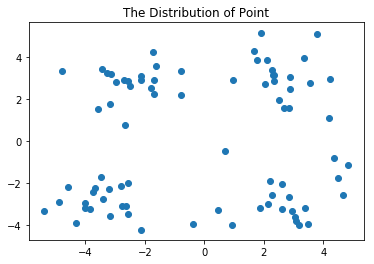

In [0]:
# 예제 데이터셋 시각화
plt.title("The Distribution of Point")
plt.scatter(dataset[:,0],dataset[:,1])
plt.show()

+ numpy code

In [0]:
def cluster_kmeans(dataset, k):    
    # (1) 중심점 초기화
    min_x = dataset[:,0].min()
    max_x = dataset[:,0].max() 
    min_y = dataset[:,1].min()
    max_y = dataset[:,1].max() 

    center_x = np.random.uniform(low=min_x, high=max_x, size=k)
    center_y = np.random.uniform(low=min_y, high=max_y, size=k)
    centroids = np.stack([center_x,center_y],axis=-1)
    
    # (2) ~ (5) 순회
    num_data = dataset.shape[0]
    cluster_per_point = np.zeros((num_data)) # 각 점 별 군집

    counter = 0
    while True:
        prev_cluster_per_point = cluster_per_point
        
        # (2) 거리 계산
        diff_mat = (centroids.reshape(-1,1,2) - dataset.reshape(1,-1,2))
        dists = np.sqrt((diff_mat**2).sum(axis=-1))
        # (3) 각 데이터를 거리가 가장 가까운 군집으로 할당
        cluster_per_point = dists.argmin(axis=0)
        
        # (4) 각 군집 별 점들의 평균을 계산 후, 군집의 중심점을 다시 계산
        for i in range(k):
            centroids[i] = dataset[cluster_per_point==i].mean(axis=0)

        if np.all(prev_cluster_per_point == cluster_per_point):
            break

        counter += 1
        plt.title("{}th Distribution of Dataset".format(counter))
        for idx, color in enumerate(['r','g','b','y']):
            mask = (cluster_per_point==idx)
            plt.scatter(dataset[mask,0],dataset[mask,1],
                        label='dataset', c=color)
            plt.scatter(centroids[:,0],centroids[:,1],
                        s=200, label="centroid", marker='+')
        plt.show()
    
    return centroids

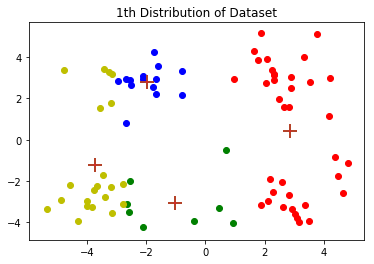

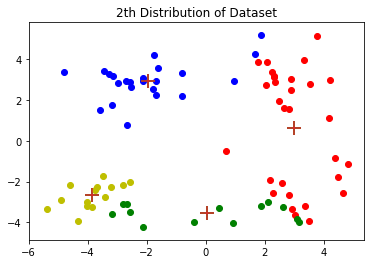

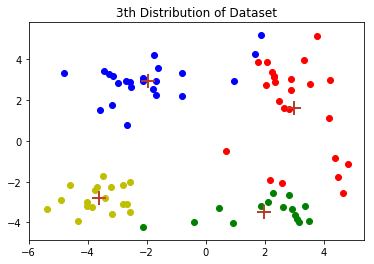

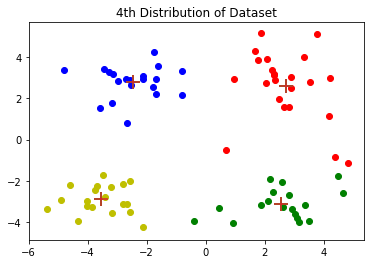

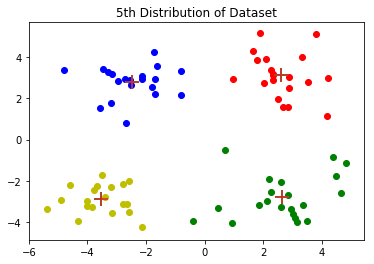

array([[ 2.6265299 ,  3.10868015],
       [ 2.65077367, -2.79019029],
       [-2.46154315,  2.78737555],
       [-3.53973889, -2.89384326]])

In [0]:
cluster_kmeans(dataset,4)

####  알고리즘 탐색하기
---
K-means의 알고리즘 순서 
​
1. 초기 중심점을 설정하기 위해 K개의 점 생성(일반적으로 임의)
2. 중심점과 각 데이터 사이의 거리를 계산
3. 각 데이터를 거리가 가장 가까운 군집으로 할당
4. 각 군집 별 점들의 평균을 계산 후, 군집의 중심점을 다시 계산
5. 2~4의 과정을 통해 각 데이터 별 군집이 바뀌지 않았으면, 이 과정을 끝냄
​
아래 코드는 Numpy 로 K-means 을 구현한 코드 입니다.<br>
​
---

####  \[ 문제 : 텐서플로우를 이용해 K-Means 구현하기 \]

텐서플로우는 numpy와 달리, Dataflow Programming 방식으로 동작합니다. <br>
우선 연산을 결정하고, 반복적인 연산은 Session 시에 진행해야 합니다.<br>



In [0]:
# 예제 데이터셋 준비하기
!wget https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/kmeans_dataset.txt
dataset = np.loadtxt("./kmeans_dataset.txt")
dataset.shape

--2019-04-26 07:44:55--  https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/kmeans_dataset.txt
Resolving s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)... 52.219.60.61
Connecting to s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)|52.219.60.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520 (1.5K) [text/plain]
Saving to: ‘kmeans_dataset.txt.7’

kmeans_dataset.txt. 100%[===================>]   1.48K  --.-KB/s    in 0s      

2019-04-26 07:44:56 (72.1 MB/s) - ‘kmeans_dataset.txt.7’ saved [1520/1520]



(80, 2)

In [0]:
tf.reset_default_graph()

graph_kmeans = tf.Graph() 
with graph_kmeans.as_default(): ## context manager로 그래프를 정의해서, 이 안에서만 graph_kmeans를 알 수 있다. 
    
    # (1) Initial value ##############################################################################################
    dataset_tf = tf.placeholder(tf.float32, shape=(None, 2), name='dataset_tf')  # shape(?, 2)
    k_tf = tf.placeholder_with_default(4, (), name='k_tf') ############# 아직 이걸 활용하지 못하고 잇음 <---------------------------

    min_x = tf.reduce_min(dataset_tf, axis=0)[0]
    min_y = tf.reduce_min(dataset_tf, axis=0)[1]
    max_x = tf.reduce_max(dataset_tf, axis=0)[0]
    max_y = tf.reduce_max(dataset_tf, axis=0)[1]
        
    center_x = tf.random.uniform(shape=[4], minval=[min_x], maxval=[max_x], dtype=tf.float32, name=None)
    center_y = tf.random.uniform(shape=[4], minval=[min_y], maxval=[max_y], dtype=tf.float32, name=None)
    centroids = tf.Variable(tf.stack([center_x,center_y],axis=-1))
    
    cluster_per_point = tf.Variable([0,0,0,0], tf.float32)  
    #################################################################################################################
    
    
    # (2) 거리 계산
    resh_cent = tf.reshape(centroids, shape=[-1,1,2])                         # centroids.shape = (4, 2) ---> (4, 1, 2)
    resh_data = tf.cast(tf.reshape(dataset_tf, shape=[1,-1,2]), tf.float32)   # dataset.shape = (80, 2) ---> (1, 80, 2)
    diff_mat = resh_cent - resh_data                                          # diff_mat.shape = (4, 80, 2)
            
    dists = tf.sqrt(tf.reduce_sum(diff_mat**2,axis=2))  # dists.shape = (4, 80)   # axis=-1 is same
    
    
    # (3) 각 데이터를 거리가 가장 가까운 군집으로 할당
    cluster_per_point = tf.argmin(dists, axis=0)# cluster_per_point.shape = (80, )

    
    # (4) 각 군집 별 점들의 평균을 계산 후, 군집의 중심점 을 다시 계산
    new_centroids_list = []
    for i in range(4):
        # 1. cluster_per_point 텐서의 각 원소 위치를 True 로 표시하는 boolean Tensor를 만듬. # equal.shape = (80,)
        equal = tf.equal(cluster_per_point, i)
        
        # 2. i 군집에 속한 vectors 텐서의 포인트들의 인덱스로 구성된 텐서를 만듬 # where.shape = (?, 1)
        where = tf.reshape(tf.where(equal), [-1,1])
        
        # 3. gather_nd 함수를 사용하여 i 군집을 이루는 점들의 좌표를 모은 텐서를 만듬. # gather.shape = (?, 2)
        gather = tf.gather_nd(dataset_tf, where) 

        # 4. reduce_mean 함수를 사용하여 i 군집에 속한 모든 점의 평균 값을 가진 텐서를 만듬 # mean.shape (2,)
        mean = tf.reduce_mean(gather, axis=0) 
        new_centroids_list.append(mean)
    
    # 결과출력용
    combine_list = tf.concat([tf.reshape(dataset_tf, [-1,2]), tf.cast(tf.reshape(cluster_per_point, [-1,1]), dtype=tf.float32)], axis=1) # combine_list.shape (80, 3)
    
    # 새로운 중심점들
    centroids = tf.assign(centroids, new_centroids_list) # centroids.shape(4, 2)

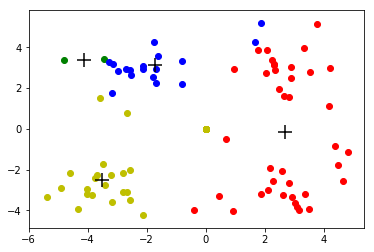

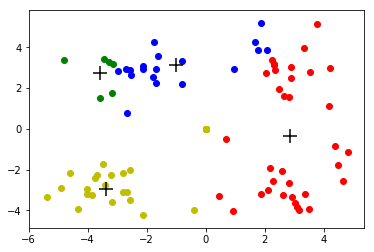

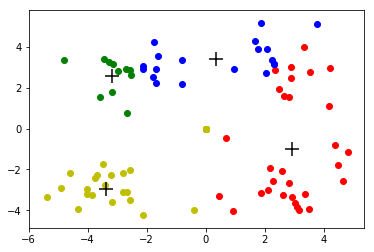

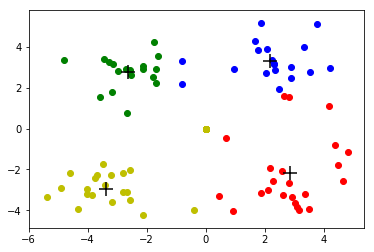

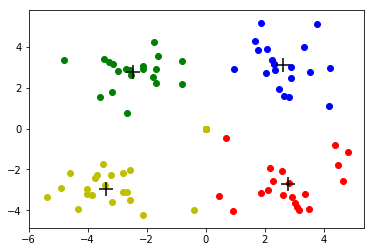

In [0]:
with graph_kmeans.as_default():
    sess = tf.Session()   #sess = tf.Session(graph=graph_kmeans) 위에 with 구문 써주면 같은 의미다.

    # sess.run(tf.global_variables_initializer()가 어떤 그래프에 대해 실행되는지 모른다 -> "with graph이름.as_default() :" 문으로 지정해줘야 한다.
    sess.run(tf.global_variables_initializer(), feed_dict={ dataset_tf : dataset, k_tf : 4})

    colors = ['r','g','b','y']

    prev_clusters = [-1]
    for i in range(100) :
        ##### run kmeans        
        centroids_, cluster_per_point_, combine_list_ = sess.run([centroids, cluster_per_point, combine_list], feed_dict={ dataset_tf : dataset, k_tf : 4})
        
        # equality check를 해야하는데, 모든 원소에 대해서 해야하므로 np.all이라는 함수를 통해서 모든 ref의 원소들이 val의 원소들과 같은 값인지 확인해야 함
        if np.all(prev_clusters == cluster_per_point_) :
            break
        else :            
            prev_clusters = cluster_per_point_
        
        for j in range(4) :
            condition = combine_list_[:,2] == j
            condition = condition.astype('int32')
            x = combine_list_[:,0] * condition
            y = combine_list_[:,1] * condition
            plt.scatter(x, y, label='dataset', c=colors[j])  
            
        plt.scatter(centroids_[:,0], centroids_[:,1], s=200, label="centroid", marker='+', c='black')
        plt.show()
        
   

### 5. Excercise - section 6 excercise 풀어오기!

In [0]:
%matplotlib inline

!pip install tensorboardcolab
import tensorboardcolab
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

In [0]:
num_data = 10000 # 데이터의 수 

data_X = np.random.normal(0,0.55,[num_data])
data_Y = data_X * 0.1 + 0.3 + np.random.normal(0,0.03,[num_data])

In [0]:
# 우선 실행해주세요
graph = tf.Graph()
with graph.as_default():
    xs = tf.placeholder(tf.float32, shape=(None,), name='x')
    y_true = tf.placeholder(tf.float32, shape=(None,), name='y_true')

    # 변수 초기화
    with tf.variable_scope('weights'):
        W = tf.Variable(tf.random.normal([1]),"W")
        b = tf.Variable(tf.zeros([1]),'b')

    # Model
    with tf.variable_scope("Linear_Regression"):
        y_pred = W * xs + b
    y_pred = tf.identity(y_pred, name="y_pred")
    
    # Loss Function
    with tf.variable_scope("losses"):
        loss = tf.reduce_mean(tf.square(y_pred - y_true))

    # Optimizer
    train_op = (tf.train
                .GradientDescentOptimizer(0.01)
                .minimize(loss))
        
    # 텐서보드를 위한 요약정보(scalar)를 정의합니다.
    tf.summary.scalar(name='W', tensor=W[0])
    tf.summary.scalar(name='b', tensor=b[0])
    tf.summary.scalar(name='loss', tensor=loss)

    # 텐서보드 요약정보들을 하나로 합칩니다.
    merged_all = tf.summary.merge_all()
                                           
    # 텐서보드에 연결합니다. 
    log_dir = "./log/"
    tbc = tensorboardcolab.TensorBoardColab(graph_path=log_dir)
             
    # 텐서보드 summary 정보들을 저장할 폴더 경로를 설정합니다.                                    
    writer = tf.summary.FileWriter(logdir=log_dir) # event file이 생김
    writer.add_graph(graph=tf.get_default_graph())                                         

Wait for 8 seconds...
TensorBoard link:
https://b97ec4e4.ngrok.io


In [0]:
# 정답을 입력해주세요
# 아래 학습 과정 중에 텐서보드를 선언하고
# Summary 연산을 통해 올려 주세요

# 조건 1. graph tensorbaord 에 연결 
# 조건 2. W, B, loss 는 scalar summary 노드를 이용해 시각화 
# 조건 3. W, B, loss 는 step 별로 추적 

# 아래는 Session을 통해 Linear Regression을 학습하는 과정입니다.
with graph.as_default():
    sess = tf.Session(graph=graph)
    sess.run(tf.global_variables_initializer())
    for step in range(1000):
        _, summary_values = sess.run([train_op, merged_all],
                                     feed_dict={
                                         xs:data_X,
                                         y_true:data_Y
                                     })   
    W_, b_ = sess.run([W,b])
        

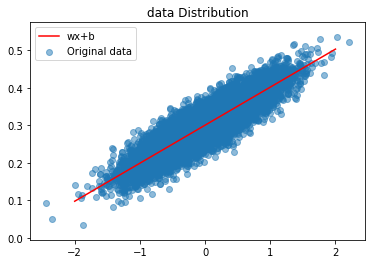

In [0]:
# print("학습된 Weight : {:.3f} Bias : {:.3f}".format(W_[0], b_[0]))

# visualization data
plt.title("data Distribution")
plt.scatter(data_X, data_Y, c='C0', label='Original data', alpha=0.5)

pred_X = np.array([-2.,2.])
pred_Y = sess.run(y_pred, feed_dict={xs:pred_X})
preds = np.stack([pred_X,pred_Y])
plt.plot(pred_X, pred_Y, color='r', label='wx+b')

plt.legend()
plt.show()